In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

In [ ]:
# Load the dataset
file_path = 'Customers_big.csv'
customers_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# Show the schema and a few rows
customers_df.printSchema()
customers_df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income ($): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Work Experience: integer (nullable = true)
 |-- Family Size: integer (nullable = true)

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|
|         3|Female| 20|            86000|                     6|     Engineer|              1|         

In [ ]:
# Remove rows with null values
customers_df = customers_df.na.drop()

In [ ]:
# Combine features into a single vector
numeric_features = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
assembler = VectorAssembler(inputCols=numeric_features, outputCol='features')

In [ ]:
# Apply the assembler
assembled_data = assembler.transform(customers_df)

In [ ]:
# StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [ ]:
# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
sse = []
silhouette_scores = []
K = range(2, 7)

for k in K:
    kmeans = KMeans(k=k, seed=42, featuresCol='scaled_features')
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)

    evaluator = ClusteringEvaluator(featuresCol='scaled_features')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

    sse.append(model.summary.trainingCost)

In [ ]:
# Choose the optimal number of clusters (e.g., k=3 from previous analysis)
optimal_k = 3
kmeans = KMeans(k=optimal_k, seed=42, featuresCol='scaled_features')
model = kmeans.fit(scaled_data)

# Make predictions
predictions = model.transform(scaled_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaled_features')
silhouette_score = evaluator.evaluate(predictions)

print(f"Silhouette Score for {optimal_k} clusters: {silhouette_score}")

Silhouette Score for 3 clusters: 0.2394559271092809


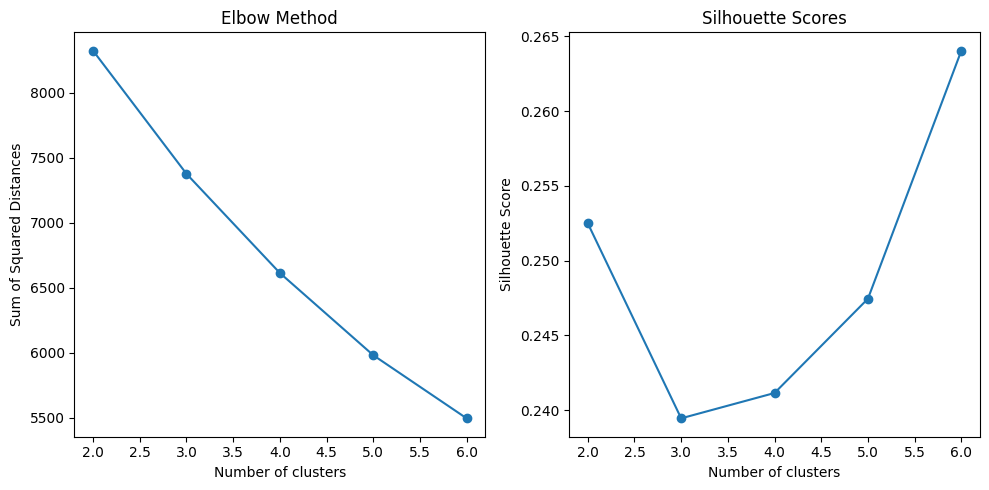

In [ ]:
# Plot the Elbow Method graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')

# Plot the Silhouette Scores graph
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

plt.tight_layout()
plt.show()

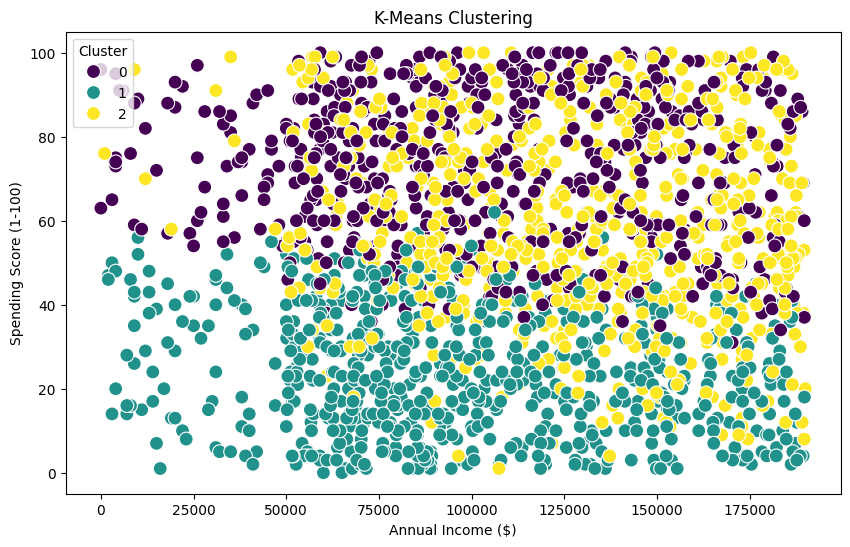

In [ ]:
# Convert to Pandas DataFrame for visualization
predictions_df = predictions.select('CustomerID', 'Annual Income ($)', 'Spending Score (1-100)', 'prediction').toPandas()
predictions_df.rename(columns={'prediction': 'Cluster'}, inplace=True)

# Visualize the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income ($)', y='Spending Score (1-100)', hue='Cluster', data=predictions_df, palette='viridis', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

Silhouette Score for 4 clusters: 0.24115052566215514


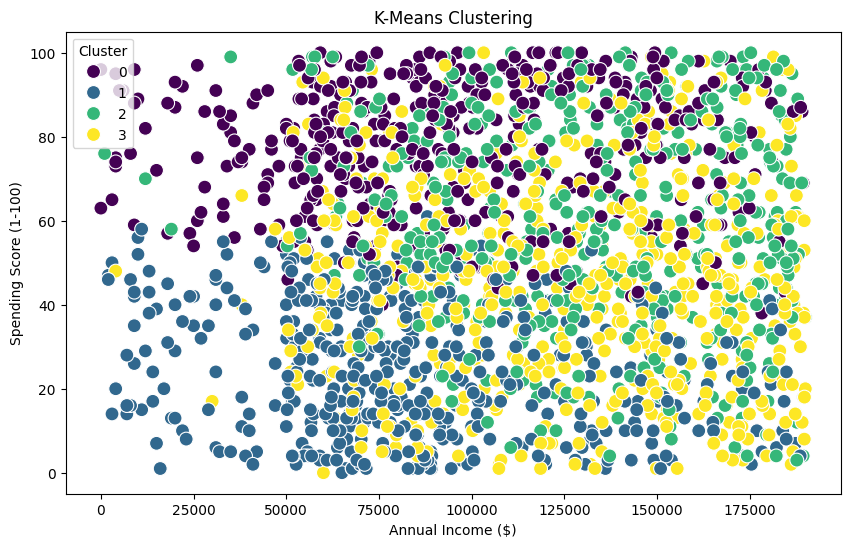

In [ ]:
# Choose the optimal number of clusters (e.g., k=4 based on the plots)
optimal_k = 4
kmeans = KMeans(k=optimal_k, seed=42, featuresCol='scaled_features')
model = kmeans.fit(scaled_data)

# Make predictions
predictions = model.transform(scaled_data)

# Evaluate clustering by computing Silhouette score
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score for {optimal_k} clusters: {silhouette_score}")

# Convert to Pandas DataFrame for visualization
predictions_df = predictions.select('CustomerID', 'Annual Income ($)', 'Spending Score (1-100)', 'prediction').toPandas()
predictions_df.rename(columns={'prediction': 'Cluster'}, inplace=True)

# Visualize the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income ($)', y='Spending Score (1-100)', hue='Cluster', data=predictions_df, palette='viridis', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

# Stop the Spark session
spark.stop()